In [16]:
import networkx as nx
import numpy as np
import pandas as pd
import datetime
import plotly.io as pio
import matplotlib.pyplot as plt
from utils import *
from read_networks import *

In [17]:
class GraphClass:
    # ==== Note: If you change a line here, please check if there's a corresponding line to be updated in the same way in ExperimentClass.add_edges_and_update ==== 
    
    def __init__(self, graph):
        print(graph)
        self.graph = graph

        # create adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.graph)

        # == nodes ==
        # degree
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))

        # opinion
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

        # conformity
        self.conformity = np.array(list(nx.get_node_attributes(self.graph, "conformity").values())).reshape((-1, 1))

        # node_centrality
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        
        # == edges ==
        # weight on edges
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]

In [19]:
class ExperimentClass(GraphClass):
    def __init__(self, graph: nx.Graph, model_name: str, df, init_date: str):
        super().__init__(graph)
        self.model_name = model_name
        self.opinions_per_iter = []
        self.avgdiff_per_iter = []
        self.opinions_std_per_iter = []
        self.df = df
        self.current_date = init_date  
        
    def add_edges_and_update(self, add_edge_list):
        self.graph.add_edges_from(add_edge_list)
        
        # several self params need to be updates with new edges:
        # adj_matrix
        self.adj_matrix = nx.to_numpy_array(self.graph)
        # degrees
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))
        # node_centrality (if estimated by degree),
        for node in self.graph.nodes: # may be improved in the future to go through affected nodes only, instead of all nodes
            self.graph.nodes[node]['node_centrality'] = 0.01 + self.graph.degree(node)
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        # weight
        for item in add_edge_list:
            self.graph.edges[item]['weight'] = np.random.rand()
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]
        
    def grab_new_edges_per_time_step(self, mode='month'):
        if mode == 'month':
            new_date = get_next_month_first_day(self.current_date)
        # can add other time steps here (e.g. multiple months = run the function several times)
        else:
            new_date = self.current_date
        
        df_add = section_dataframe(self.df, self.current_date, new_date)
        edges_add = df_to_list_of_edges(df_add)
        return edges_add, new_date

    def run_model(self, steps: int):
        self.initial_opinions = self.opinions.copy()

        for _ in range(1, steps):
            if self.model_name == 'FJ':
                # since edge weights have not been well maintained, use node centrality nc_i as w_ii and nc_j as w_ij
                new_opinions = (self.adj_matrix @ (self.node_centrality * self.opinions) + self.node_centrality * self.initial_opinions) / (self.adj_matrix @ self.node_centrality + self.node_centrality + 0.001)
            elif self.model_name == 'Abebe':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ self.opinions) / (self.degrees + 0.001)
            elif self.model_name == 'new':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ (self.node_centrality * self.opinions)) / ((self.adj_matrix @ self.node_centrality) + 0.001)

            # print(new_opinions)
            # print(self.opinions)
            #print(new_opinions)
            difference = np.abs(new_opinions - self.opinions)
            avg_difference = difference.sum() / len(self.opinions)
            
            # statistics of each iteration
            self.opinions_per_iter.append(new_opinions)
            self.avgdiff_per_iter.append(avg_difference) # avg difference from last iter
            self.opinions_std_per_iter.append(np.std(new_opinions)) # std of opinions
            #print(np.std(new_opinions))
            
            # update graph
            self._update_graph(new_opinions)

    def _update_graph(self, new_opinions):
        for i, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['opinion'] = new_opinions[i][0]
        
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))
        # ==== TBD: also update susceptability at each iteration ====
        
        # grab the new edges to be added, and update current date/time
        new_edges_list, new_date = self.grab_new_edges_per_time_step()
        print('Added # edges', len(new_edges_list))
        print(new_date)
        self.add_edges_and_update(new_edges_list)
        self.current_date = new_date

    def plot(self):
        # plot each time of sum of opinions
        fig, ax = plt.subplots(figsize=(10, 5))
        #ax.plot(np.array(self.opinions_std_per_iter).sum(axis=1))
        ax.plot(np.array(self.opinions_std_per_iter))
        #print(np.array(self.opinions_per_iter).sum(axis=1))
        ax.set_xlabel('time')
        ax.set_ylabel('std of opinions')
        ax.set_title(f'Standard Deviation of opinions over time ({self.model_name})')
        plt.show()

    def get_opinions_per_iter(self):
        return self.opinions_per_iter
    def get_avgdiff_per_iter(self):
        return self.avgdiff_per_iter
    def get_opinions_std_per_iter(self):
        return self.opinions_std_per_iter

In [20]:
from read_networks import read_combined_graph_from_csv, read_citation_graph_from_edgelist

# g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
#g = read_citation_graph_from_edgelist (field='History', graph=nx.Graph())
g_simple, g_init, init_date, df = read_combined_graph_from_csv(
    field='History',
    init_cutoff_date = '2019-03-01',
    graph=nx.Graph())
print(g_simple, f"is_directed: {g_simple.is_directed()}")
print(g_init, f"is_directed: {g_init.is_directed()}")
print(g_simple)
print(init_date)

Graph with 2288 nodes and 5677 edges is_directed: False
Graph with 2288 nodes and 127 edges is_directed: False
Graph with 2288 nodes and 5677 edges
2019-03-01


In [21]:
def create_graph(random_seed=42):
    np.random.seed(random_seed)
    
    # g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
    # g = read_citation_graph_from_edgelist (field='History', graph=nx.Graph())
    g_simple, g_init, init_date, df = read_combined_graph_from_csv(field='History', init_cutoff_date = '2019-03-31', graph=nx.Graph())
    print(g_simple)
    print(g_init)
    
    # add node properties such as weight and opinion
    # ==== Note: If you change a line here, please check if there's a corresponding line to be updated in the same way in ExperimentClass.add_edges_and_update ==== 

    for node in g_init.nodes:
        g_init.nodes[node]['opinion'] = 0

    # Initialize with a given timpstamp.
    # If nodes are connected before this timestamp, they share a same init opinion.
    for node in g_init.nodes:
        has_opinion_flag = False
        for init_nbr in g_init.neighbors(node):
            if g_init.nodes[init_nbr]['opinion'] != 0:
                g_init.nodes[node]['opinion'] = g_init.nodes[init_nbr]['opinion']
                has_opinion_flag = True
                break
        if not has_opinion_flag:
            # use gaussian distribution
            g_init.nodes[node]['opinion'] = np.random.normal(0.5, 0.1)
        # print(g_init.nodes[node]['opinion'])

        g_init.nodes[node]['conformity'] = np.random.uniform(0, 1)
        g_init.nodes[node]['node_centrality'] = 0.01 + g_init.degree(node) # approx by citations
    

    # add edge weight
    for e1, e2 in g_init.edges:
        g_init.edges[e1, e2]['weight'] = np.random.rand()
        # g_init.edges[e1, e2]['weight'] = np.random.rand()
    
    return g_simple, g_init, init_date, df

# # display thier properties
# for node in g.nodes:
#     print(g.nodes[node])

Graph with 2288 nodes and 5677 edges
Graph with 2288 nodes and 173 edges
Graph with 2288 nodes and 173 edges
Added # edges 0
2019-04-01
Added # edges 25
2019-05-01
Added # edges 22
2019-06-01
Added # edges 135
2019-07-01
Added # edges 105
2019-08-01
Added # edges 101
2019-09-01
Added # edges 184
2019-10-01
Added # edges 77
2019-11-01
Added # edges 190
2019-12-01
Added # edges 196
2020-01-01
Added # edges 396
2020-02-01
Added # edges 277
2020-03-01
Added # edges 152
2020-04-01
Added # edges 61
2020-05-01
Added # edges 206
2020-06-01
Added # edges 581
2020-07-01
Added # edges 407
2020-08-01
Added # edges 114
2020-09-01
Added # edges 467
2020-10-01
Added # edges 394
2020-11-01
Added # edges 1401
2020-12-01
Added # edges 403
2021-01-01
Added # edges 0
2021-02-01
Added # edges 0
2021-03-01
Added # edges 0
2021-04-01
Added # edges 0
2021-05-01
Added # edges 0
2021-06-01
Added # edges 0
2021-07-01
Added # edges 0
2021-08-01
[0.24361804786119745, 0.07963301775423126, 0.039915099513324996, 0.02

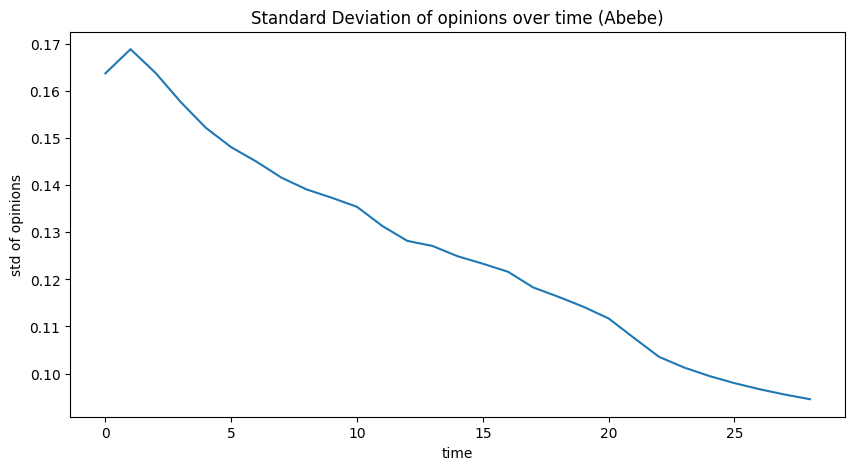

Graph with 2288 nodes and 173 edges
Added # edges 0
2019-04-01
Added # edges 25
2019-05-01
Added # edges 22
2019-06-01
Added # edges 135
2019-07-01
Added # edges 105
2019-08-01
Added # edges 101
2019-09-01
Added # edges 184
2019-10-01
Added # edges 77
2019-11-01
Added # edges 190
2019-12-01
Added # edges 196
2020-01-01
Added # edges 396
2020-02-01
Added # edges 277
2020-03-01
Added # edges 152
2020-04-01
Added # edges 61
2020-05-01
Added # edges 206
2020-06-01
Added # edges 581
2020-07-01
Added # edges 407
2020-08-01
Added # edges 114
2020-09-01
Added # edges 467
2020-10-01
Added # edges 394
2020-11-01
Added # edges 1401
2020-12-01
Added # edges 403
2021-01-01
Added # edges 0
2021-02-01
Added # edges 0
2021-03-01
Added # edges 0
2021-04-01
Added # edges 0
2021-05-01
Added # edges 0
2021-06-01
Added # edges 0
2021-07-01
Added # edges 0
2021-08-01
[0.24360005345531524, 0.07962985203879386, 0.03988013522980296, 0.024444987159198826, 0.017233248918422834, 0.01304226653349195, 0.01036717605

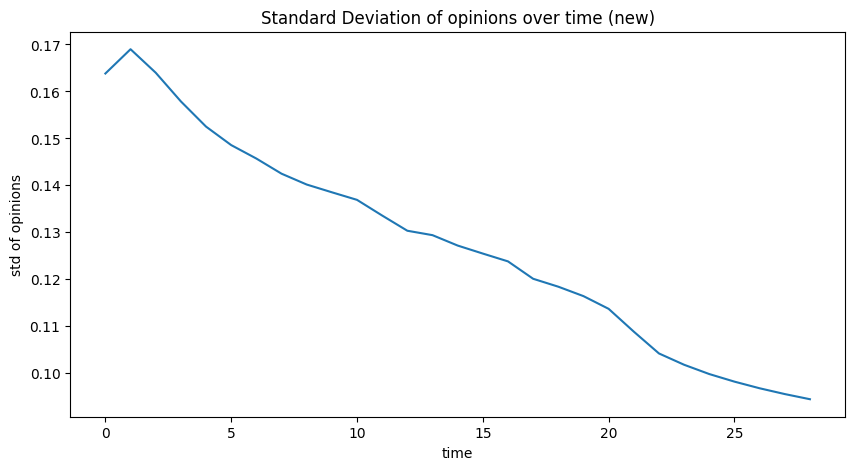

In [22]:
import plotly.graph_objects as go
# mode = ['FJ', 'Abebe', 'new']
mode = ['Abebe', 'new']
fig = go.Figure()
_, test_graph, init_date, df = create_graph()
for i in mode:
    graph = test_graph.copy()
    test = ExperimentClass(graph, i, df, init_date)
    test.run_model(30)
    avgdiff_per_iter = test.get_avgdiff_per_iter()
    print(avgdiff_per_iter)
    opinions_std_per_iter = test.get_opinions_std_per_iter()
    print(opinions_std_per_iter)
    test.plot()
    fig.add_trace(go.Scatter(x=np.arange(1, len(avgdiff_per_iter)+1), y=opinions_std_per_iter, mode='lines', name=f'{i}'))
fig.update_layout(title=f'Opinions Std over time', 
                  xaxis_title='step', yaxis_title='Avg difference in opinions',
                  title_x=0.5, title_y=0.85,
                  legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="right",
                    x=0.99
                  ),
                  width=600, height=400)
# update x ticks to every 1
fig.update_xaxes(dtick=1)
fig.update_layout
fig.show()

# # Save the figure with a high resolution (dpi=300)
pio.write_image(fig, 'avg_diff.jpeg', width=600, height=400, scale=10)

In [9]:
test.graph.number_of_edges(), test.graph.number_of_nodes()

(5851, 2288)

In [9]:
# only try this when having sufficient time and PC memory
'''plt.figure(figsize = (15,15))
nx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],
    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])
plt.savefig('start.svg')'''

"plt.figure(figsize = (15,15))\nnx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],\n    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])\nplt.savefig('start.svg')"

## Interate Component

In [10]:
plt.figure(figsize = (5,5))
g_simple = test_graph.copy()

<Figure size 500x500 with 0 Axes>

In [11]:
list(nx.connected_components(g_simple))
subgraph_20 = []
for i in list(nx.connected_components(g_simple)):
    if len(i) == 20:
        subgraph = i
        subgraph_20.append(subgraph)
# random select one subgraph
subgraph = subgraph_20[1]

IndexError: list index out of range

In [12]:
pos = nx.spring_layout(g_simple)

KeyboardInterrupt: 

Graph with 11870 nodes and 19683 edges


/var/folders/y1/fh786ynd5w516vt3ry98bgp00000gn/T/ipykernel_35999/2742584444.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



0.707655918229493
0.4804282422099595
0.4262340436568156
0.35564042917436584
0.2790727963199281


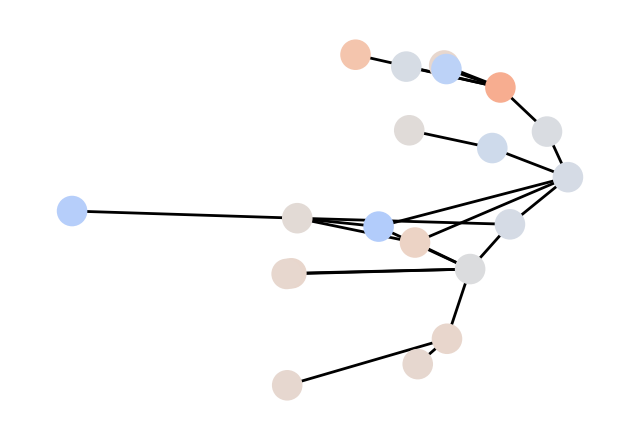

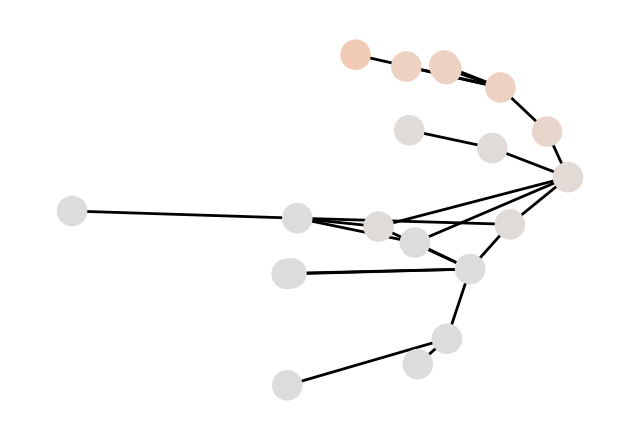

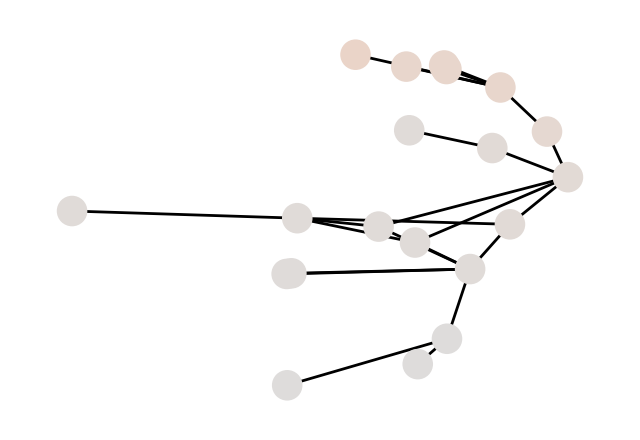

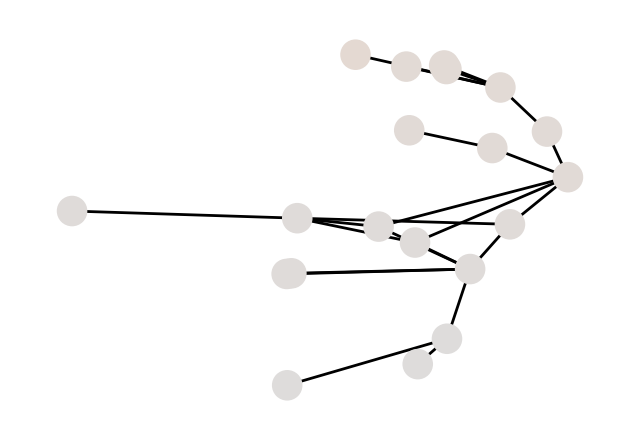

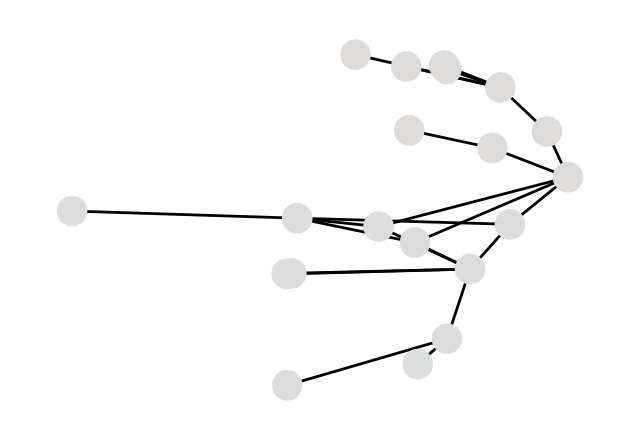

In [ ]:
cnt = 1
%config InlineBackend.figure_format = 'retina'
test = ExperimentClass(g_simple, 'Abebe')
# set a continuous color scale to map opinions to colors
plt.figure(figsize=(3, 2))
cmap = plt.cm.get_cmap('coolwarm')
node_sizes = [g_simple.nodes[node]['node_centrality']*10000 for node in g_simple.subgraph(subgraph).nodes]
# node_colors = [g_simple.nodes[node]['opinion']*10000 for node in g_simple.subgraph(subgraph).nodes]
node_colors = [cmap(g_simple.nodes[node]['opinion']) for node in g_simple.subgraph(subgraph).nodes]
print(g_simple.nodes[node]['opinion'])
# always draw the nodes in the same place
nx.draw(g_simple.subgraph(subgraph), pos=pos, node_size=node_sizes, node_color=node_colors, width=1)
plt.savefig(f'figures/opinion_0.jpeg', dpi=300)

while cnt < 5:
    test.run_model(20*cnt)
    # draw subgraph of g_simple
    plt.figure(figsize=(3, 2))
    node_sizes = [g_simple.nodes[node]['node_centrality']*10000 for node in g_simple.subgraph(subgraph).nodes]
    # node_colors = [g_simple.nodes[node]['opinion']*10000 for node in g_simple.subgraph(subgraph).nodes]
    node_colors = [cmap(g_simple.nodes[node]['opinion']) for node in g_simple.subgraph(subgraph).nodes]
    print(g_simple.nodes[node]['opinion'])
    # always draw the nodes in the same place
    nx.draw(g_simple.subgraph(subgraph), pos=pos, node_size=node_sizes, node_color=node_colors, width=1)
    plt.savefig(f'figures/opinion_{cnt}.jpeg', dpi=300)

    cnt += 1


In [ ]:
G = nx.lollipop_graph(4,3)
elist = G.edges()
print(elist)
G1 = nx.Graph()

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (5, 6)]


In [ ]:
import datetime
#from datautil import relativedelta
datestr = '2022-01-31'
daterep = datetime.datetime.strptime(datestr, '%Y-%m-%d').date()
#nextmonth = daterep + relativedelta.relativedelta(months=1)
print(daterep)

2022-01-31


In [ ]:
dt_new = (daterep.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)
print(str(dt_new))  

2022-02-01
